### Import libraries and utility functions

In [6]:
"""
Import required libraries and define utility functions for image processing.
"""
import cv2
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

### Load image and mask files

In [7]:
"""
Load image and mask files from specified directories.
"""
def process_image(image_path, output_mask_folder):
    """Process an image to extract spheroid properties with enhanced smoothing."""
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    blurred = cv2.GaussianBlur(image, (5, 5), 0)
    _, thresholded = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)

    cleaned = cv2.morphologyEx(thresholded, cv2.MORPH_OPEN, np.ones((3,3), np.uint8))
    cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_CLOSE, np.ones((5,5), np.uint8))
    
    contours, _ = cv2.findContours(cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    if len(contours) == 0:
        print("No contours found")
        return None, None, None

    largest_contour = max(contours, key=cv2.contourArea)
    original_area = cv2.contourArea(largest_contour)

    # 1) Fourier smoothing with more aggressive smoothing
    smoothed_points = smooth_contour_fourier(largest_contour, num_freqs=15)  # Reduce num_freqs for more smoothing

    # 2) Scale the smoothed contour so it retains the original area
    scaled_points = scale_contour_to_match_area(smoothed_points, original_area)

    # 3) Apply convex hull for additional smoothing
    hull = cv2.convexHull(scaled_points.reshape(-1,1,2).astype(np.int32))

    # 4) Fill the convex hull contour to create a final mask
    final_mask = np.zeros_like(image)
    cv2.fillPoly(final_mask, [hull], 255)

    # 5) Apply a final Gaussian blur for ultra-smooth results
    final_mask = cv2.GaussianBlur(final_mask, (5,5), 0)

    contours_smoothed, _ = cv2.findContours(final_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours_smoothed) == 0:
        print("No contours found after smoothing.")
        return None, None, None
    
    largest_smoothed = max(contours_smoothed, key=cv2.contourArea)
    area = cv2.contourArea(largest_smoothed)
    perimeter = cv2.arcLength(largest_smoothed, True)
    circularity = (4 * np.pi * area) / (perimeter ** 2) if perimeter > 0 else 0

    base_name = os.path.splitext(os.path.basename(image_path))[0]
    output_filename = base_name + "_mask.png"
    output_path = os.path.join(output_mask_folder, output_filename)
    cv2.imwrite(output_path, final_mask)
    
    return area, perimeter, circularity

### Preprocess and visualize masks

In [16]:
"""
Preprocess mask images and visualize them for initial inspection.
"""
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

def show_image(title, img, cmap='gray'):
    plt.figure(figsize=(6, 6))
    plt.title(title)
    plt.imshow(img, cmap=cmap)
    plt.axis('off')
    plt.show()

def process_single_image(image_path):
    """Process a single image and show all steps without saving anything."""
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    show_image("Original", image)

    # Step 1: Blur
    blurred = cv2.GaussianBlur(image, (5, 5), 0)
    show_image("Blurred", blurred)

    # Step 2: Threshold
    _, thresholded = cv2.threshold(blurred, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
    show_image("Thresholded (Otsu + Inverse)", thresholded)

    # Step 3: Morphology
    cleaned = cv2.morphologyEx(thresholded, cv2.MORPH_OPEN, np.ones((3,3), np.uint8))
    cleaned = cv2.morphologyEx(cleaned, cv2.MORPH_CLOSE, np.ones((5,5), np.uint8))
    show_image("Morphological Cleaning", cleaned)

    # Step 4: Contours
    contours, _ = cv2.findContours(cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours) == 0:
        print("No contours found")
        return None, None, None

    largest_contour = max(contours, key=cv2.contourArea)
    original_area = cv2.contourArea(largest_contour)

    # Step 5: Fourier smoothing
    smoothed_points = smooth_contour_fourier(largest_contour, num_freqs=15)
    vis_smooth = np.zeros_like(image)
    cv2.drawContours(vis_smooth, [smoothed_points.astype(np.int32)], -1, 255, 1)
    show_image("Smoothed Contour (Fourier)", vis_smooth)

    # Step 6: Scale contour to match original area
    scaled_points = scale_contour_to_match_area(smoothed_points, original_area)

    # Step 7: Convex hull
    hull = cv2.convexHull(scaled_points.reshape(-1, 1, 2).astype(np.int32))
    vis_hull = np.zeros_like(image)
    cv2.drawContours(vis_hull, [hull], -1, 255, 1)
    show_image("Convex Hull", vis_hull)

    # Step 8: Final mask fill + blur
    final_mask = np.zeros_like(image)
    cv2.fillPoly(final_mask, [hull], 255)
    final_mask = cv2.GaussianBlur(final_mask, (5, 5), 0)
    show_image("Final Smoothed Mask", final_mask)

    # Step 9: Measurement
    contours_smoothed, _ = cv2.findContours(final_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if len(contours_smoothed) == 0:
        print("No contours found after smoothing.")
        return None, None, None

    largest_smoothed = max(contours_smoothed, key=cv2.contourArea)
    area = cv2.contourArea(largest_smoothed)
    perimeter = cv2.arcLength(largest_smoothed, True)
    circularity = (4 * np.pi * area) / (perimeter ** 2) if perimeter > 0 else 0

    return area, perimeter, circularity

### Overlay masks on original images

In [14]:
"""
Overlay original images with corresponding masks for visual comparison.
"""
def smooth_contour_fourier(contour, num_freqs=20):
    """
    Smooth the given contour using Fourier descriptors, keeping only 'num_freqs' low frequencies.
    Smaller num_freqs => more smoothing; Larger => less smoothing.
    Returns a new array of shape (N,2) for the smoothed contour (float32).
    """
    # Reshape from (N,1,2) to (N,2)
    contour_points = contour.squeeze(axis=1)  # shape: (N,2)
    xs = contour_points[:, 0]
    ys = contour_points[:, 1]

    # Convert to complex: z = x + i*y
    z = xs + 1j*ys
    Z = np.fft.fft(z)
    N = len(Z)

    # Zero out high-frequency components beyond +/- num_freqs
    num_freqs = min(num_freqs, N//2)
    Z[num_freqs : N - num_freqs] = 0

    # Inverse FFT
    z_smooth = np.fft.ifft(Z)

    xs_smooth = np.real(z_smooth)
    ys_smooth = np.imag(z_smooth)

    smoothed_points = np.column_stack((xs_smooth, ys_smooth)).astype(np.float32)
    return smoothed_points

def scale_contour_to_match_area(points, target_area):
    """
    Scales the smoothed contour so that its area matches 'target_area'.
    Steps:
      1) Compute centroid
      2) Measure current area
      3) Scale about centroid by sqrt(target_area / current_area)
    """
    # Compute centroid
    cx = np.mean(points[:,0])
    cy = np.mean(points[:,1])

    # Current area
    c_tmp = points.reshape(-1,1,2).astype(np.float32)
    current_area = cv2.contourArea(c_tmp)
    if current_area < 1e-6:
        return points  # area too small, can't scale meaningfully

    # Scale factor
    scale_factor = np.sqrt(target_area / current_area)

    # Shift to centroid -> scale -> shift back
    pts_shifted = points.copy()
    pts_shifted[:,0] -= cx
    pts_shifted[:,1] -= cy

    pts_scaled = pts_shifted * scale_factor

    pts_scaled[:,0] += cx
    pts_scaled[:,1] += cy

    return pts_scaled

### Resize and binarize masks

In [11]:
"""
Resize, threshold, and binarize mask images to prepare for segmentation.
"""
def extract_time_from_filename(filename):
    """Extracts the day and hour from the filename based on naming conventions."""
    try:
        parts = filename.split('_')
        time_part = parts[-1].split('d')
        day = int(time_part[0][-2:])  # Extracts the last two digits before 'd' as day
        hour = int(time_part[1][:2])  # Extracts the two digits after 'd' as hour
        return day, hour
    except:
        return None, None

### Label and visualize regions

In [18]:
"""
Label binary mask regions and generate visualizations for each labeled segment.
"""
def process_condition(folder_path, condition_name):
    """Processes a single condition (folder) and returns aggregated results."""
    results = []
    output_mask_folder = os.path.join(folder_path, "segmented_masks")
    os.makedirs(output_mask_folder, exist_ok=True)

    for filename in sorted(os.listdir(folder_path)):
        if filename.endswith(('.jpg', '.png')):
            image_path = os.path.join(folder_path, filename)
            day, hour = extract_time_from_filename(filename)

            if day is not None:
                area, perimeter, circularity = process_image(image_path, output_mask_folder)
                if area is not None:
                    time_label = f"{day}d{hour}h"
                    µm_per_px = condition_scales[condition_name]
                    area_um2 = area * (µm_per_px ** 2)
                    perimeter_um = perimeter * µm_per_px
                    results.append([filename, time_label, day, hour, area_um2, perimeter_um, circularity, condition_name])


    df = pd.DataFrame(results, columns=["Filename", "Time Label", "Day", "Hour", "Area", "Perimeter", "Circularity", "Condition"])
    df["Time (Days)"] = df["Day"] + df["Hour"] / 24.0

    # Compute mean & SD per timepoint
    df_grouped = df.groupby(["Condition", "Time Label"]).agg(
        Mean_Area=("Area", "mean"),
        SD_Area=("Area", "std"),
        Mean_Perimeter=("Perimeter", "mean"),
        SD_Perimeter=("Perimeter", "std"),
        Mean_Circularity=("Circularity", "mean"),
        SD_Circularity=("Circularity", "std"),
        Time_Days=("Time (Days)", "mean")
    ).reset_index()

    # Merge final timepoints (~6d21h)
    df_grouped.loc[df_grouped["Time_Days"] >= 6 + 21/24, "Time Label"] = "Final_Time"
    df_final = df_grouped.groupby(["Condition", "Time Label"], as_index=False).agg(
        Mean_Area=("Mean_Area", "mean"),
        SD_Area=("SD_Area", "mean"),
        Mean_Perimeter=("Mean_Perimeter", "mean"),
        SD_Perimeter=("SD_Perimeter", "mean"),
        Mean_Circularity=("Mean_Circularity", "mean"),
        SD_Circularity=("SD_Circularity", "mean"),
        Time_Days=("Time_Days", "mean")
    ).sort_values(by=["Condition", "Time_Days"])

    return df_final

def main(conditions, output_csv):
    """Processes multiple conditions and plots comparisons."""
    all_data = []

    for folder_path, condition_name in conditions.items():
        df_condition = process_condition(folder_path, condition_name)
        all_data.append(df_condition)

    df_all = pd.concat(all_data, ignore_index=True)
    df_all.to_csv(output_csv, index=False)
    print(f"Results saved to {output_csv}")

    # **Plot each condition as a different color**
    plt.figure(figsize=(8,5))
    sns.lineplot(data=df_all, x="Time_Days", y="Mean_Area", hue="Condition", marker="o", style="Condition", linewidth=2)
    plt.fill_between(df_all["Time_Days"], df_all["Mean_Area"] - df_all["SD_Area"], df_all["Mean_Area"] + df_all["SD_Area"], alpha=0.2)
    plt.xlabel("Time (Days)")
    plt.ylabel("Spheroid Area (px²)")
    plt.title("Spheroid Area Over Time (Comparison)")
    plt.legend()
    plt.grid()
    plt.show()

    plt.figure(figsize=(8,5))
    sns.lineplot(data=df_all, x="Time_Days", y="Mean_Perimeter", hue="Condition", marker="o", style="Condition", linewidth=2)
    plt.fill_between(df_all["Time_Days"], df_all["Mean_Perimeter"] - df_all["SD_Perimeter"], df_all["Mean_Perimeter"] + df_all["SD_Perimeter"], alpha=0.2)
    plt.xlabel("Time (Days)")
    plt.ylabel("Spheroid Perimeter (px)")
    plt.title("Spheroid Perimeter Over Time (Comparison)")
    plt.legend()
    plt.grid()
    plt.show()

    plt.figure(figsize=(8,5))
    sns.lineplot(data=df_all, x="Time_Days", y="Mean_Circularity", hue="Condition", marker="o", style="Condition", linewidth=2)
    plt.fill_between(df_all["Time_Days"], df_all["Mean_Circularity"] - df_all["SD_Circularity"], df_all["Mean_Circularity"] + df_all["SD_Circularity"], alpha=0.2)
    plt.xlabel("Time (Days)")
    plt.ylabel("Spheroid Circularity")
    plt.title("Spheroid Circularity Over Time (Comparison)")
    plt.legend()
    plt.grid()
    plt.show()

### Visualization

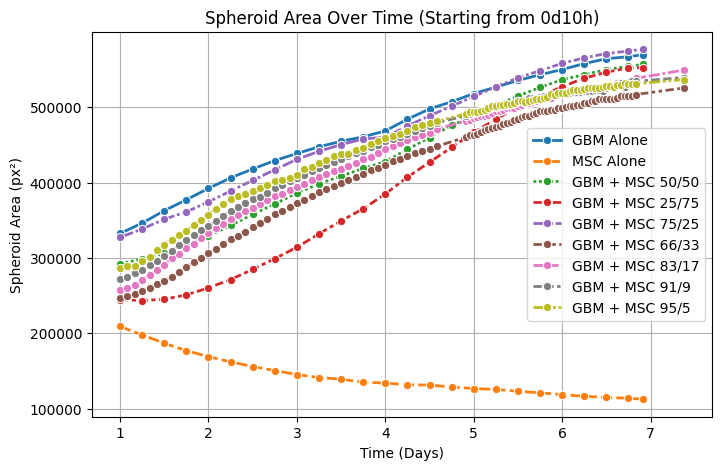

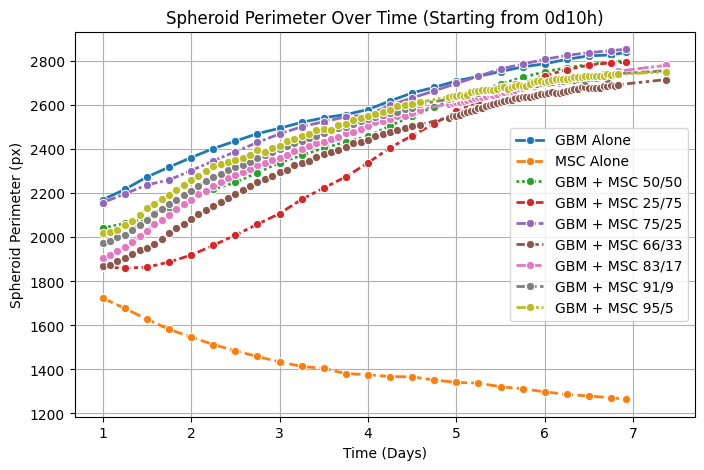

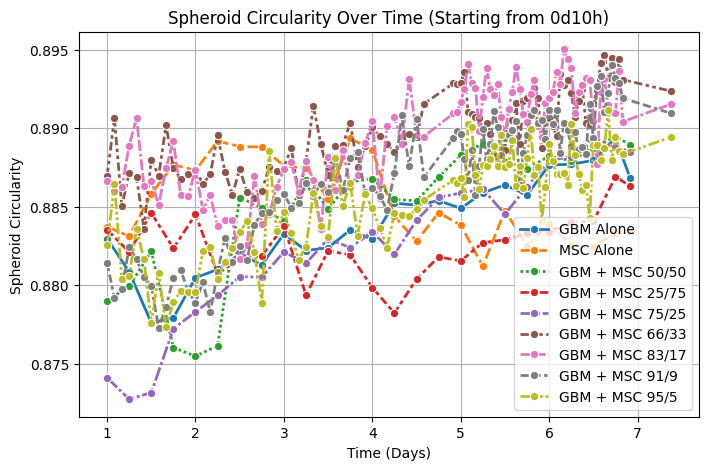

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the CSV file
output_csv = "../data/experimental_data_analysis/spheroid_comparison_2.csv"
df_all = pd.read_csv(output_csv)

# Filter to start from Time >= 0d10h (0.4167 days)
df_all = df_all[df_all["Time_Days"] >= 0.99]

# Plot Area
plt.figure(figsize=(8,5))
sns.lineplot(data=df_all, x="Time_Days", y="Mean_Area", hue="Condition", marker="o", style="Condition", linewidth=2)
plt.xlabel("Time (Days)")
plt.ylabel("Spheroid Area (px²)")
plt.title("Spheroid Area Over Time (Starting from 0d10h)")
plt.legend()
plt.grid()
plt.show()

# Plot Perimeter
plt.figure(figsize=(8,5))
sns.lineplot(data=df_all, x="Time_Days", y="Mean_Perimeter", hue="Condition", marker="o", style="Condition", linewidth=2)
plt.xlabel("Time (Days)")
plt.ylabel("Spheroid Perimeter (px)")
plt.title("Spheroid Perimeter Over Time (Starting from 0d10h)")
plt.legend()
plt.grid()
plt.show()

# Plot Circularity
plt.figure(figsize=(8,5))
sns.lineplot(data=df_all, x="Time_Days", y="Mean_Circularity", hue="Condition", marker="o", style="Condition", linewidth=2)
plt.xlabel("Time (Days)")
plt.ylabel("Spheroid Circularity")
plt.title("Spheroid Circularity Over Time (Starting from 0d10h)")
plt.legend()
plt.grid()
plt.show()